# Imports and set up

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_PATH = '/home/dreamtim/Coding/ITMO/itmo-cpp/with_smiles.csv'
SEED = 42

# Load the data

In [3]:
df = pd.read_csv(DATA_PATH)
df

,sequence,extra_name,cpp_category,seq_length,cpp_type,origin,mol_weight,is_cpp_3,sequence_category,standard_sequence,...,biotinylated,acylated_n_terminal,cyclic,amidated,stearyl_uptake,hexahistidine_tagged,modifications,adjusted_sequence,smiles_sequence,is_valid_smiles
0,(Acp)-KKKKKRFSFKKSFKLSGFSFKKNKK,NaN,NaN,31,NaN,NaN,NaN,yes,Peptide with Substitutions,AKKKKKRFSFKKSFKLSGFSFKKNKK,...,False,False,False,False,False,False,"[('C', 2), ('P', 3)]",AKKKKKRFSFKKSFKLSGFSFKKNKKXXXXXXXXXXXXXXXXXXXX...,CC(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[...,True
1,(Acp)-RKRRQTSMTDFYHSKRRLIFS,NaN,NaN,27,NaN,NaN,NaN,yes,Peptide with Substitutions,ARKRRQTSMTDFYHSKRRLIFS,...,False,False,False,False,False,False,"[('C', 2), ('P', 3)]",ARKRRQTSMTDFYHSKRRLIFSXXXXXXXXXXXXXXXXXXXXXXXX...,CCC(C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC...,True
2,(biotin)-lclrpvgggweaklakalakalakhlakalakalkacea,NaN,NaN,48,NaN,NaN,NaN,yes,Biotinylated,NaN,...,True,False,False,False,False,False,[],NaN,NC(=O)CCC(=O)NC1CCCCC1,True
3,(biotin)-lclrpvggrsqsrsryyrqrqrsrrrrrrs,NaN,NaN,39,NaN,NaN,NaN,yes,Biotinylated,NaN,...,True,False,False,False,False,False,[],NaN,NC(=O)CCC(=O)NC1CCCCC1,True
4,?A-RR-[KRRRRRE],NaN,NaN,15,NaN,NaN,NaN,yes,Unknown,ARRKRRRRRE,...,False,False,False,False,False,False,[],ARRKRRRRREXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...,C[C@H](N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,vrlpppvrlpppvrlppp,NaN,NaN,18,NaN,NaN,NaN,yes,Enantiomer Mix,NaN,...,False,False,False,False,False,False,[],NaN,CC(C)C[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H...,True
2918,ykqchkkGGkkGsG,NaN,NaN,14,NaN,NaN,NaN,yes,Enantiomer Mix,GGGG,...,False,False,False,False,False,False,"[('Y', 1), ('K', 2), ('Q', 3), ('C', 4), ('H',...",GGGGXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...,NCCCC[C@H](NC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC(...,True
2919,"α,ε(Stearyl-AGYLLG)2KINLKALAALAKKIL",NaN,NaN,35,NaN,NaN,NaN,yes,Uptake with Stearyl,SAGYLLGKINLKALAALAKKIL,...,False,False,False,False,True,False,"[('T', 2), ('E', 3), ('A', 4), ('R', 5), ('Y',...",SAGYLLGKINLKALAALAKKILXXXXXXXXXXXXXXXXXXXXXXXX...,CCCCCCCCCCCCCCCC(=O)N[C@@H](C)C(=O)NCC(=O)N[C@...,True
2920,δ-(Stearyl-AGYLLG)OINLKALAALAKKIL,NaN,NaN,33,NaN,NaN,NaN,yes,Uptake with Stearyl,NaN,...,False,False,False,False,True,False,"[('T', 2), ('E', 3), ('A', 4), ('R', 5), ('Y',...",NaN,CCCCCCCCCCCCCCCC(=O)N[C@@H](C)C(=O)NCC(=O)N[C@...,True


In [5]:
df_filtered = df.pipe(
    lambda x: x[x.is_cpp_3.isin(['yes', 'no'])]
).pipe(
    lambda x: x[x.is_valid_smiles]
)

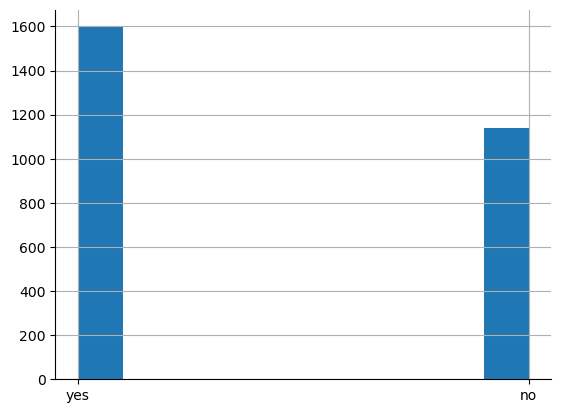

In [6]:
df_filtered.is_cpp_3.hist()
sns.despine()
plt.show()

In [7]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2737 entries, 0 to 2921
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sequence              2737 non-null   object 
 1   extra_name            174 non-null    object 
 2   cpp_category          747 non-null    object 
 3   seq_length            2737 non-null   int64  
 4   cpp_type              76 non-null     object 
 5   origin                7 non-null      object 
 6   mol_weight            0 non-null      float64
 7   is_cpp_3              2737 non-null   object 
 8   sequence_category     2737 non-null   object 
 9   standard_sequence     2533 non-null   object 
 10  nh3_tail              2737 non-null   bool   
 11  po3_pos               2737 non-null   bool   
 12  biotinylated          2737 non-null   bool   
 13  acylated_n_terminal   2737 non-null   bool   
 14  cyclic                2737 non-null   bool   
 15  amidated              2737

# Baseline models

In [8]:
# For data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# For evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

### Classification with Morgan fingerprints

##### Prepare

In [9]:
FINGERPRINTS_PATH = '/home/dreamtim/Coding/ITMO/itmo-cpp/morgan_fingerprints.npy'
embeddings = np.load(FINGERPRINTS_PATH)
embeddings.shape

(2922, 1024)

In [13]:
df_with_embeddings = df.copy()
for i in range(embeddings.shape[1]):
    df_with_embeddings[f'fingerprint_{i}'] = embeddings[:, i]

df_with_embeddings

,sequence,extra_name,cpp_category,seq_length,cpp_type,origin,mol_weight,is_cpp_3,sequence_category,standard_sequence,...,fingerprint_1014,fingerprint_1015,fingerprint_1016,fingerprint_1017,fingerprint_1018,fingerprint_1019,fingerprint_1020,fingerprint_1021,fingerprint_1022,fingerprint_1023
0,(Acp)-KKKKKRFSFKKSFKLSGFSFKKNKK,NaN,NaN,31,NaN,NaN,NaN,yes,Peptide with Substitutions,AKKKKKRFSFKKSFKLSGFSFKKNKK,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,(Acp)-RKRRQTSMTDFYHSKRRLIFS,NaN,NaN,27,NaN,NaN,NaN,yes,Peptide with Substitutions,ARKRRQTSMTDFYHSKRRLIFS,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,(biotin)-lclrpvgggweaklakalakalakhlakalakalkacea,NaN,NaN,48,NaN,NaN,NaN,yes,Biotinylated,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,(biotin)-lclrpvggrsqsrsryyrqrqrsrrrrrrs,NaN,NaN,39,NaN,NaN,NaN,yes,Biotinylated,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,?A-RR-[KRRRRRE],NaN,NaN,15,NaN,NaN,NaN,yes,Unknown,ARRKRRRRRE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,vrlpppvrlpppvrlppp,NaN,NaN,18,NaN,NaN,NaN,yes,Enantiomer Mix,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2918,ykqchkkGGkkGsG,NaN,NaN,14,NaN,NaN,NaN,yes,Enantiomer Mix,GGGG,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2919,"α,ε(Stearyl-AGYLLG)2KINLKALAALAKKIL",NaN,NaN,35,NaN,NaN,NaN,yes,Uptake with Stearyl,SAGYLLGKINLKALAALAKKIL,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2920,δ-(Stearyl-AGYLLG)OINLKALAALAKKIL,NaN,NaN,33,NaN,NaN,NaN,yes,Uptake with Stearyl,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df_with_embeddings_filtered = df_with_embeddings.pipe(
    lambda x: x[x.is_cpp_3.isin(['yes', 'no'])]
).pipe(
    lambda x: x[x.is_valid_smiles]
)

In [15]:
df_with_embeddings_filtered

,sequence,extra_name,cpp_category,seq_length,cpp_type,origin,mol_weight,is_cpp_3,sequence_category,standard_sequence,...,fingerprint_1014,fingerprint_1015,fingerprint_1016,fingerprint_1017,fingerprint_1018,fingerprint_1019,fingerprint_1020,fingerprint_1021,fingerprint_1022,fingerprint_1023
0,(Acp)-KKKKKRFSFKKSFKLSGFSFKKNKK,NaN,NaN,31,NaN,NaN,NaN,yes,Peptide with Substitutions,AKKKKKRFSFKKSFKLSGFSFKKNKK,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,(Acp)-RKRRQTSMTDFYHSKRRLIFS,NaN,NaN,27,NaN,NaN,NaN,yes,Peptide with Substitutions,ARKRRQTSMTDFYHSKRRLIFS,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,(biotin)-lclrpvgggweaklakalakalakhlakalakalkacea,NaN,NaN,48,NaN,NaN,NaN,yes,Biotinylated,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,(biotin)-lclrpvggrsqsrsryyrqrqrsrrrrrrs,NaN,NaN,39,NaN,NaN,NaN,yes,Biotinylated,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,?A-RR-[KRRRRRE],NaN,NaN,15,NaN,NaN,NaN,yes,Unknown,ARRKRRRRRE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,vrlpppvrlpppvrlppp,NaN,NaN,18,NaN,NaN,NaN,yes,Enantiomer Mix,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2918,ykqchkkGGkkGsG,NaN,NaN,14,NaN,NaN,NaN,yes,Enantiomer Mix,GGGG,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2919,"α,ε(Stearyl-AGYLLG)2KINLKALAALAKKIL",NaN,NaN,35,NaN,NaN,NaN,yes,Uptake with Stearyl,SAGYLLGKINLKALAALAKKIL,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2920,δ-(Stearyl-AGYLLG)OINLKALAALAKKIL,NaN,NaN,33,NaN,NaN,NaN,yes,Uptake with Stearyl,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
columns_to_drop_for_embeddings = df_with_embeddings_filtered.columns.to_list()
# Rempve target and embeddings columns from to drop list
columns_to_drop_for_embeddings.remove('is_cpp_3')
columns_to_drop_for_embeddings = [col for col in columns_to_drop_for_embeddings if 'fingerprint' not in col]

In [18]:
df_with_embeddings_clean = df_with_embeddings_filtered.drop(columns=columns_to_drop_for_embeddings)

In [19]:
df_with_embeddings_encoded = df_with_embeddings_clean.copy()
bool_cols = df_with_embeddings_encoded.columns[df_with_embeddings_encoded.dtypes == 'bool'].tolist()
for col in bool_cols:
    df_with_embeddings_encoded[col] = df_with_embeddings_encoded[col].astype(int)

label_encoder = LabelEncoder()
df_with_embeddings_encoded['is_cpp_3'] = label_encoder.fit_transform(df_with_embeddings_encoded['is_cpp_3'])

X_emb = df_with_embeddings_encoded.drop('is_cpp_3', axis=1)
y_emb = df_with_embeddings_encoded['is_cpp_3']

X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(
    X_emb, y_emb, test_size=0.2, random_state=42, stratify=y_emb
)

In [20]:
# print shapes
print(f"Training set shape: {X_train_emb.shape}")
print(f"Testing set shape: {X_test_emb.shape}")

Training set shape: (2189, 1024)
Testing set shape: (548, 1024)


In [23]:
def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix'):
    """
    Plots a confusion matrix using seaborn heatmap.

    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.
    labels (list): List of label names.
    title (str): Title of the plot.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

##### Catboost

In [21]:
from catboost import CatBoostClassifier


In [24]:
cat_clf_emb = CatBoostClassifier(random_state=SEED, verbose=0)

cat_clf_emb.fit(X_train_emb, y_train_emb)

In [26]:
y_pred_cat_emb = cat_clf_emb.predict(X_test_emb)

print("CatBoost with Morgan fingerprints Classification Report:")

print(classification_report(y_test_emb, y_pred_cat_emb))

CatBoost with Morgan fingerprints Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       228
           1       0.85      0.87      0.86       320

    accuracy                           0.83       548
   macro avg       0.83      0.83      0.83       548
weighted avg       0.83      0.83      0.83       548



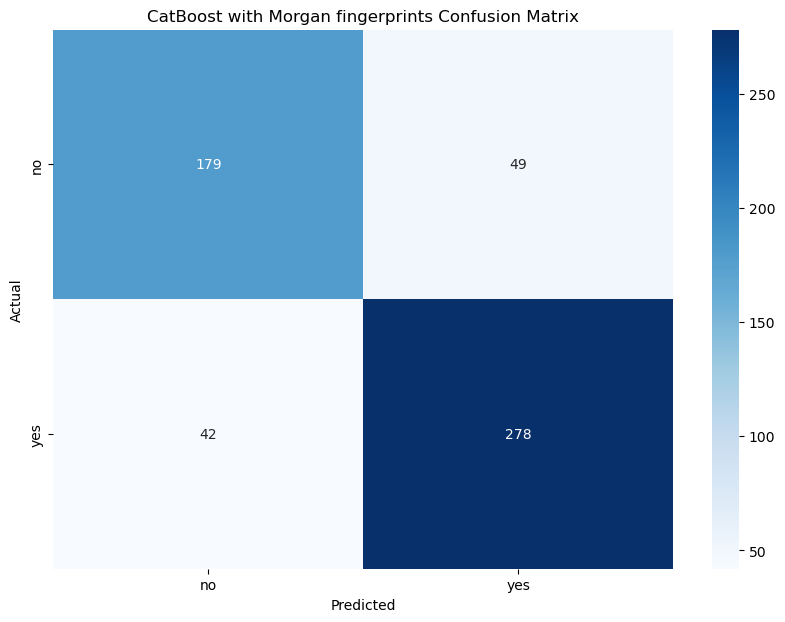

In [27]:
plot_confusion_matrix(y_test_emb, y_pred_cat_emb, labels=['no', 'yes'], title='CatBoost with Morgan fingerprints Confusion Matrix')

In [37]:
f1_score(y_test_emb, y_pred_cat_emb)

0.8593508500772797

### EDA of the embeddings

In [28]:
X_combined = pd.concat([X_train_emb, X_test_emb])
y_combined = pd.concat([y_train_emb, y_test_emb])


##### Dimensionality reduction

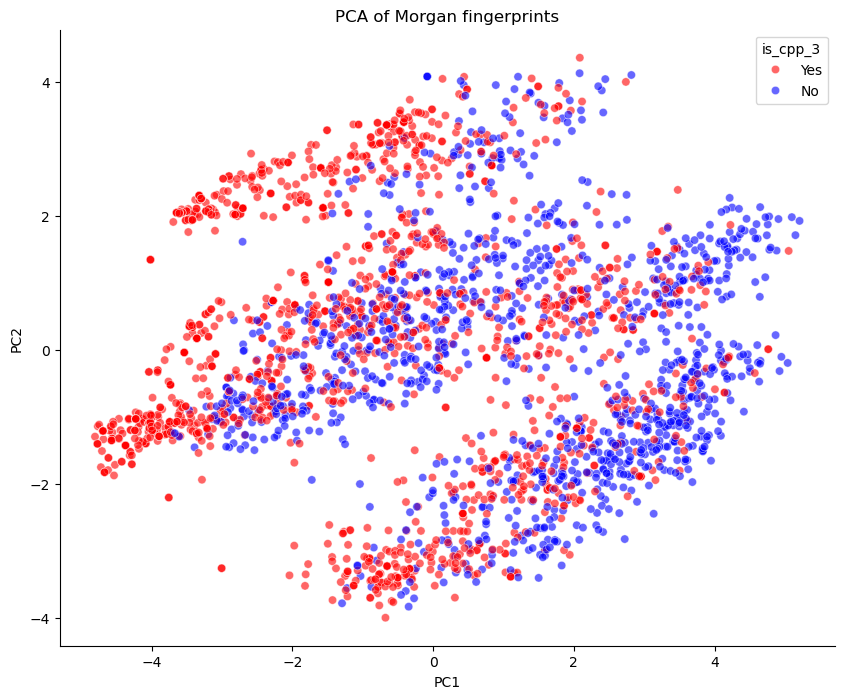

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_combined)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Class'] = ['No' if label == 0 else 'Yes' for label in y_combined]  # Ensure 'Class' column with 'No'/'Yes'

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Class', palette=['red', 'blue'], data=pca_df, alpha=0.6)
plt.title('PCA of Morgan fingerprints')
plt.legend(title='is_cpp_3')  # Correct legend title
sns.despine()
plt.show()

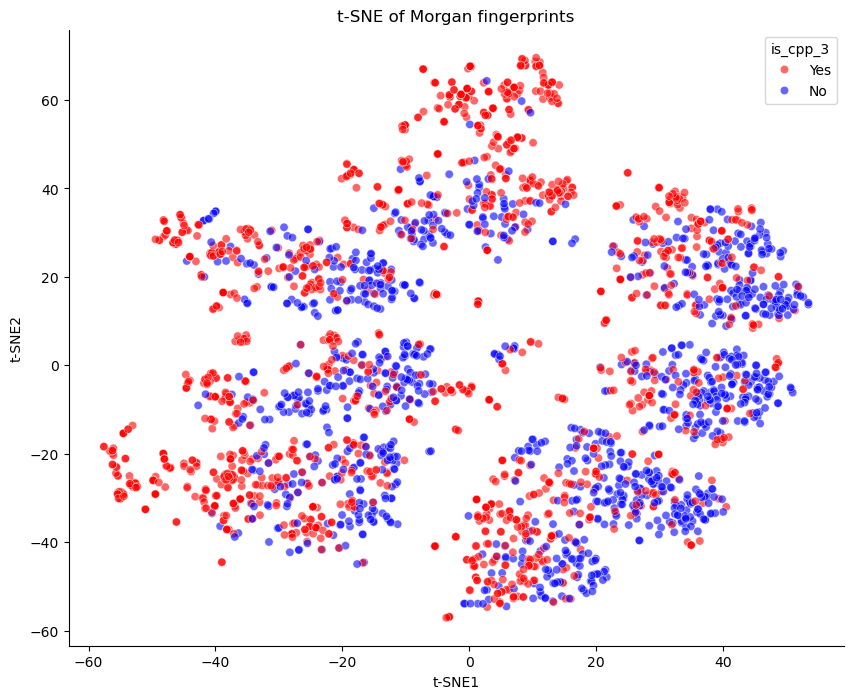

In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

tsne = TSNE(n_components=2, random_state=SEED)

X_tsne = tsne.fit_transform(X_combined)

tsne_df = pd.DataFrame(data=X_tsne, columns=['t-SNE1', 't-SNE2'])
tsne_df['Class'] = ['No' if label == 0 else 'Yes' for label in y_combined]  # Ensure 'Class' column with 'No'/'Yes'

plt.figure(figsize=(10, 8))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Class', palette=['red', 'blue'], data=tsne_df, alpha=0.6)
plt.title('t-SNE of Morgan fingerprints')
plt.legend(title='is_cpp_3')  # Correct legend title
sns.despine()
plt.show()

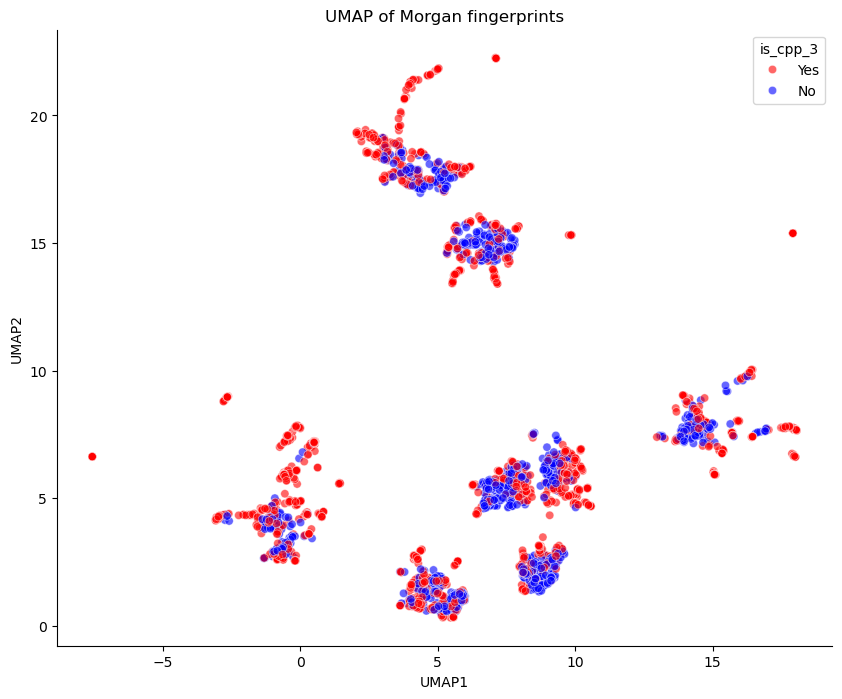

In [36]:
import umap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

umap_emb = umap.UMAP(random_state=SEED)

X_umap = umap_emb.fit_transform(X_combined)

umap_df = pd.DataFrame(data=X_umap, columns=['UMAP1', 'UMAP2'])
umap_df['Class'] = ['No' if label == 0 else 'Yes' for label in y_combined]  # Ensure 'Class' column with 'No'/'Yes'

plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Class', palette=['red', 'blue'], data=umap_df, alpha=0.6)
plt.title('UMAP of Morgan fingerprints')
plt.legend(title='is_cpp_3')  # Correct legend title
sns.despine()
plt.show()